# 3MD3220: Reinforcement Learning - Individual Assignment

**Author:** Alexandre Boistard 
**Date:** March 2025

---

## Introduction

This notebook presents the implementation and comparison of two 
reinforcement learning agents— a Monte Carlo-based agent and a Sarsa 
agent—applied to the Text Flappy Bird (TFB) environment. 

In this notebook, two RL approaches are implemented:
1. A **Monte Carlo-based agent** that learns by averaging returns over 
complete episodes.
2. A **Sarsa agent** that utilizes eligibility traces to incrementally 
update its policy based on temporal-difference error.

The notebook is structured as follows:
- **Preliminaries:** Importing libraries, environment setup, and state 
discretization functions.
- **Agent Implementations:** Detailed code for both the Monte Carlo and 
Sarsa(λ) agents.
- **Training and Evaluation:** Training loops, performance tracking, and 
parameter sweeps.
- **Results and Analysis:** Visualization of rewards, state-value functions,
 and discussion of findings.

This structured approach allows us to compare the convergence properties, 
stability, and adaptability of both agents under different environmental 
configurations.

Environment configuration: {'height': 15, 'width': 20, 'pipe_gap': 4}
Random seeds set for reproducibility.


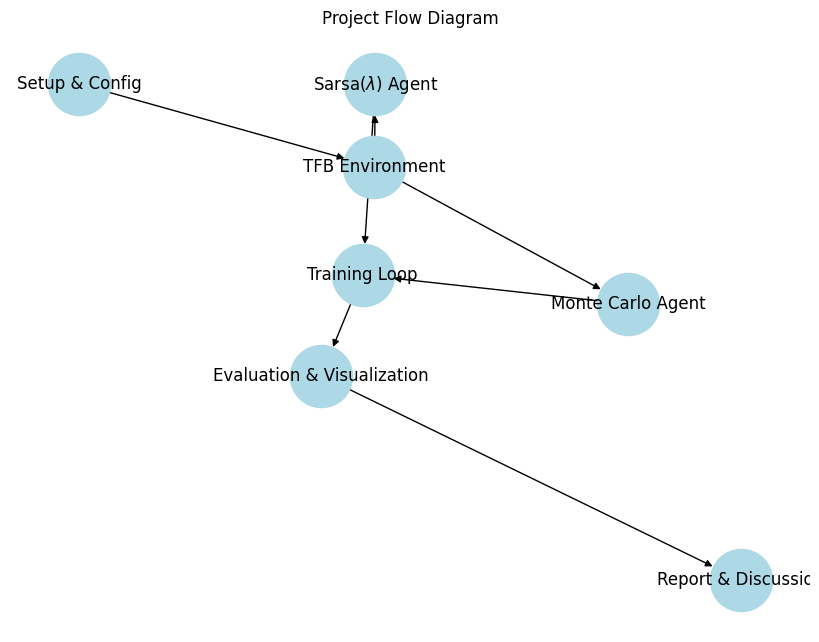

In [109]:
# Step 1.1: Environment and Reproducibility Setup
import numpy as np
import random
import matplotlib.pyplot as plt
import os, sys
import gymnasium as gym
import time
from collections import defaultdict
from tqdm import tqdm
from rl_glue import RLGlue

# Set environment parameters
env_config = {
    'height': 15,
    'width': 20,
    'pipe_gap': 4
}

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Environment configuration:", env_config)
print("Random seeds set for reproducibility.")

# Step 1.2: Visual Project Flow Diagram
import networkx as nx

# Define the high-level components of the project
G = nx.DiGraph()
G.add_edges_from([
    ("Setup & Config", "TFB Environment"),
    ("TFB Environment", "Monte Carlo Agent"),
    ("TFB Environment", "Sarsa($\lambda$) Agent"),
    ("Monte Carlo Agent", "Training Loop"),
    ("Sarsa($\lambda$) Agent", "Training Loop"),
    ("Training Loop", "Evaluation & Visualization"),
    ("Evaluation & Visualization", "Report & Discussion")
])

pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
plt.title("Project Flow Diagram")
plt.show()


In [110]:
# Step 2: Initialize the TFB Environment
from gymnasium.envs.registration import register

register(
    id='TextFlappyBird-v0',
    entry_point='text_flappy_bird_gym.envs:TextFlappyBirdEnvSimple'
) ## can be deleted, forces the access to the environment if the environment 
# if necessary

env = gym.make('TextFlappyBird-v0', **env_config)
print("Environment initialized and rendered successfully.")

Environment initialized and rendered successfully.


In [111]:
## step 2.1: get some general observation on the env
# Print basic information about the environment.
print("Environment Observation Space:", env.observation_space)
print("Environment Action Space:", env.action_space)

# Reset the environment to get the initial state.
initial_state = env.reset()
print("\nInitial observation type:", type(initial_state))
print("Initial observation content:")

# If the observation is a dictionary, print its keys and the dictionary.
if isinstance(initial_state, dict):
    print("Observation keys:", list(initial_state.keys()))
    for key, value in initial_state.items():
        print(f"{key}: {value}")
# If it's a numpy array or another type, print directly.
else:
    print(initial_state)

Environment Observation Space: Tuple(Discrete(14), Discrete(22, start=-11))
Environment Action Space: Discrete(2)

Initial observation type: <class 'tuple'>
Initial observation content:
((13, 3), {'score': 0, 'player': [6, 7], 'distance': np.float64(13.341664064126334)})


In [153]:
obs = env.reset()
print(obs)
## we first play randomly
# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    print(reward, info)
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()


((13, -3), {'score': 0, 'player': [6, 7], 'distance': np.float64(13.341664064126334)})
1 {'score': 0, 'player': [6, 6], 'distance': np.float64(12.649110640673518)}
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-4)
1 {'score': 0, 'player': [6, 5], 'distance': np.float64(12.083045973594572)}
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      

In [193]:
class MonteCarloAgent:
    def __init__(self, env, alpha, gamma=1.0, eps_start=1.0, eps_decay=0.99999, eps_min=0.05, rand_gen=0):
        """
        Initializes the Monte Carlo agent.
        
        Parameters:
            env: The environment following the OpenAI Gym interface.
            alpha: Step-size parameter.
            gamma: Discount factor.
            eps_start: Initial epsilon value for the epsilon-greedy policy.
            eps_decay: Multiplicative factor for decreasing epsilon per episode.
            eps_min: Minimum epsilon value.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.nA = env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.rand_gen = np.random.default_rng(rand_gen)

    def get_probs(self, Q_s, epsilon):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        policy_s = np.ones(self.nA) * epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] += 1 - epsilon 
        return policy_s

    def generate_episode_from_Q(self, epsilon):
        """ generates an episode from following the epsilon-greedy policy """
        episode = []
        state = self.env.reset()[0]
        while True:
            action = np.random.choice(np.arange(self.nA), 
            p=self.get_probs(self.Q[state], epsilon)) \
            if state in self.Q else self.env.action_space.sample()
            # take a step in the environement 
            next_state, reward, done, _, info = self.env.step(action) 
            episode.append((state, action, reward,info['score']))
            state = next_state
            if done:
                break
        return episode

    def update_Q(self, episode):
        """ updates the action-value function estimate using the most recent episode """
        states, actions, rewards, current_score = zip(*episode)
        # prepare for discounting
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_Q + self.alpha * (np.dot(discounts[:len
        (rewards)-i], rewards[i:]) - old_Q)
        return self.Q


    def train(self, num_episodes, display=False):
        nA = self.nA
        self.Q = defaultdict(lambda: np.zeros(nA))
        epsilon = self.eps_start
        scores = []  
        for i_episode in range(1, num_episodes+1):
            if display and i_episode % 1000 == 0:
                print(f"\rEpisode {i_episode}/{num_episodes}.", end="")
                sys.stdout.flush()
            # Decay epsilon
            epsilon = max(epsilon * self.eps_decay, self.eps_min)
            # Generate an episode using the current Q
            episode = self.generate_episode_from_Q(epsilon)
            # Compute the score for this episode
            scores.append(max([score for _,_,_,score in episode])) 
            # Update Q based on the episode
            self.Q = self.update_Q(episode)
        # Build the final policy from the updated Q-table
        policy = {state: np.argmax(actions) for state, actions in self.Q.items()}
        return policy, self.Q, scores


In [195]:
# obtain the estimated optimal policy and action-value function
alpha = 0.02
num_ep = 5000

agent = MonteCarloAgent(env,alpha)
policy, Q, _ = agent.train(num_ep,display=True)

Episode 5000/5000.

In [196]:
# obtain the corresponding state-value function and plot
V = dict((k,np.max(v)) for k, v in Q.items())

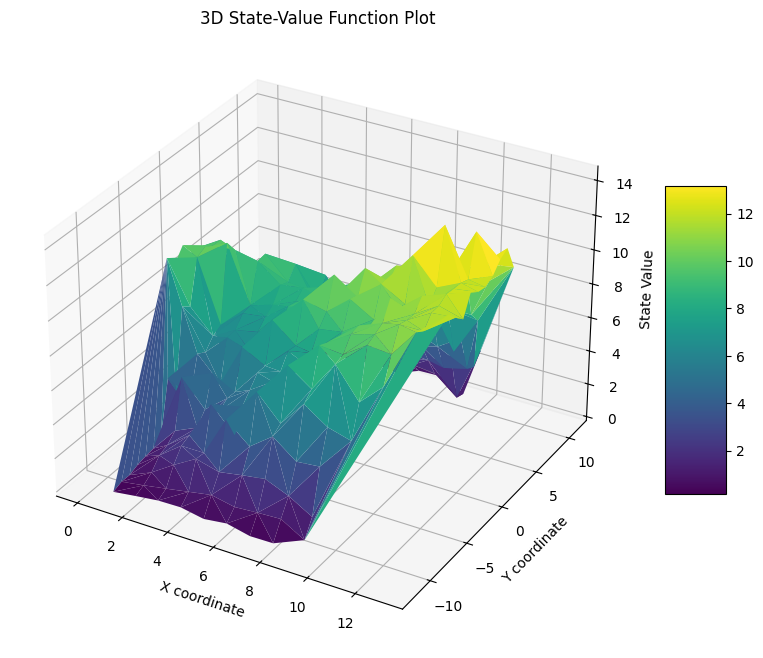

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection


# Convert dictionary keys and values into arrays
keys = np.array(list(V.keys()))
values = np.array(list(V.values()))

# Extract x and y coordinates from keys
X = keys[:, 0]
Y = keys[:, 1]
Z = values

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use plot_trisurf to plot the 3D surface for irregularly spaced data
surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_zlabel('State Value')
ax.set_title('3D State-Value Function Plot')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # add a color bar

plt.show()

In [200]:
## we make our agent play !!! 
obs = env.reset()[0]
# iterate
i=0
while True:

    # Select next action
    action = policy[obs] # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    i+=1
    # If player is dead break
    if done or i==100:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=2)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[       

In [235]:
from tqdm import trange

def run_monte_carlo_experiment(env, agent_class, alpha=0.1, gamma=1.0,
                               eps_start=1.0, eps_decay=0.99999, eps_min=0.05,
                               num_runs=10, num_episodes=500, seed_offset=0):
    all_rewards = np.zeros((num_runs, num_episodes))
    all_scores = np.zeros((num_runs, num_episodes))
    for run in range(num_runs):
        agent = agent_class(env, alpha=alpha, gamma=gamma,
                            eps_start=eps_start, eps_decay=eps_decay,
                            eps_min=eps_min, rand_gen=seed_offset + run)
        epsilon = eps_start
        for ep in trange(num_episodes, desc=f" alpha: {alpha} and Run: "
                                            f"{run+1}/{num_runs}", leave=False):
            episode = agent.generate_episode_from_Q(epsilon)
            ep_return = sum(step[2] for step in episode)
            final_score = max(step[3] for step in episode)
            all_rewards[run, ep] = ep_return
            all_scores[run, ep] = final_score
            agent.update_Q(episode)
            epsilon = max(epsilon * eps_decay, eps_min)
    return all_rewards, all_scores

def bin_and_plot_data(all_data, bin_size=100, confidence=0.95):
    num_runs, num_episodes = all_data.shape
    num_bins = num_episodes // bin_size
    binned_x, binned_means, binned_errors = [], [], []
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        run_bin_means = np.mean(all_data[:, start:end], axis=1)
        mean_bin = np.mean(run_bin_means)
        std_bin = np.std(run_bin_means)
        se = std_bin / np.sqrt(num_runs)
        t_value = 1.96  # for 95% confidence
        error = t_value * se
        binned_x.append(start + bin_size / 2)
        binned_means.append(mean_bin)
        binned_errors.append(error)
    return np.array(binned_x), np.array(binned_means), np.array(binned_errors)

In [248]:
# Main plotting logic
env = gym.make('TextFlappyBird-v0', **env_config)
alpha_values = [0.01, 0.1, 0.5, 0.9]
num_runs = 1 # around 10 min per run for 4 alpha values and 50000 episodes
## we rather use bins of episodes to find averages
num_episodes = 50000

all_rewards = {}
all_scores = {}

for alpha in alpha_values:
    all_rewards[alpha], all_scores[alpha] = run_monte_carlo_experiment(
        env=env,
        agent_class=MonteCarloAgent,
        alpha=alpha,
        gamma=1.0,
        eps_start=1.0,
        eps_decay=0.9999,
        eps_min=0.05,
        num_runs=num_runs,
        num_episodes=num_episodes,
        seed_offset=42
    )

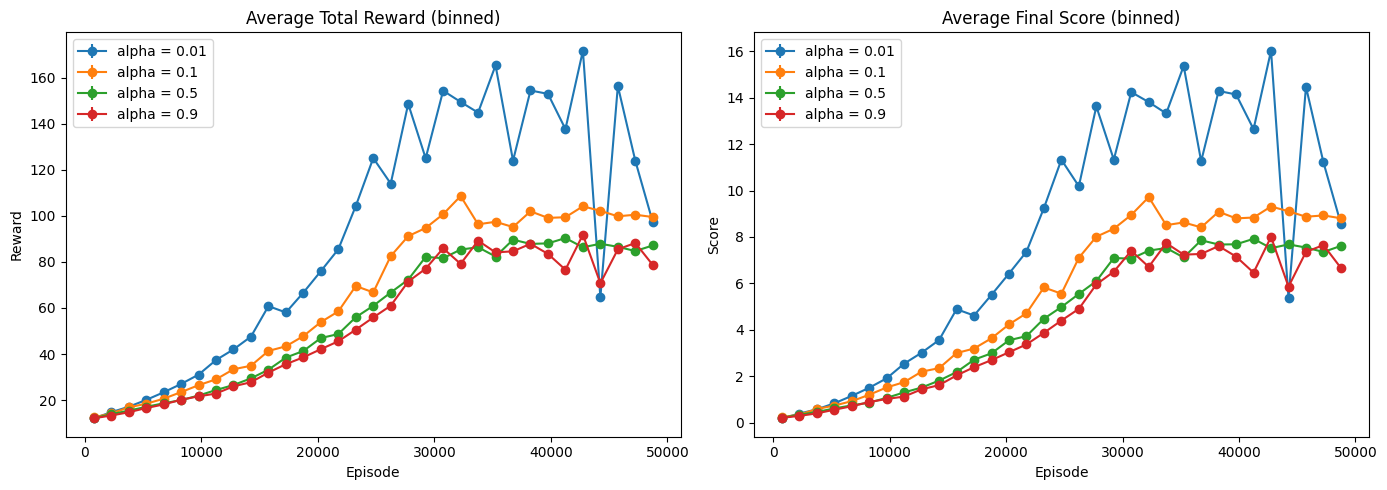

In [253]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bin_size = 1500
for alpha in alpha_values:
    x_r, mean_r, err_r = bin_and_plot_data(all_rewards[alpha], bin_size=bin_size)
    x_s, mean_s, err_s = bin_and_plot_data(all_scores[alpha], bin_size=bin_size)

    axes[0].errorbar(x_r, mean_r, yerr=err_r, fmt='o-', label=f"alpha = {alpha}")
    axes[1].errorbar(x_s, mean_s, yerr=err_s, fmt='o-', label=f"alpha = {alpha}")

axes[0].set_title("Average Total Reward (binned)")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].legend()

axes[1].set_title("Average Final Score (binned)")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Score")
axes[1].legend()

plt.tight_layout()
plt.show()